# Site selection protocol for the i-trees project

As part of the i-Trees project a major data collection campaign will be started in 2023. Over the course of the summer the cooling effect of different tree species will be assessed in 6 different cities in the Netherlands.

There are tens of thousands of trees under municipal management in the respective cities. This poses the question of how to select the trees to be studied. Additional requirements for the selection are that trees in each city should be similarly situated. This prompts the need for a reproduceable approach for tree selection (hereafter the tree selection protocol).

The tree selection follows different tracks and is applied in a step by step process:

1. All trees should be at least 25m away from water surfaces

then, further 

2. trees in parks.
3. trees in street canyons.

for both avenues, different criteria area applied. 

__Trees in parks:__

- trees shall be at least x m away from other landuse
- trees shall be isolated from other trees (free standing), which is assessed by calculating the crown cover % in a x m buffer around each tree.
- trees shall be in a specific density environment which is assessed by calculating the Floor Space Index (a built up area density measure) in a x m buffer around it.

__Trees in street canyons:__

- trees shall be located in streets that are oriented e-w (within a healthy margin) so building shadows don't interfere with the measurements.
- trees shall be located in streets with a width >= x.
- trees shall be located in streets with a h/w ratio of <= x.
- trees shall be isolated from other trees (free standing), which is assessed by calculating the crown cover % in a x m buffer around each tree.


---------

If not already done, please install all libraries and dependencies using the environment.txt file using:

$ conda create -n <environment-name> --file req.txt

<div>
<img src="../documents/protocol.jpeg" width="1000"/>
</div>

## Section 0: Import modules and functions

### Section 0.1: Modules

In [1]:
import pandas as pd
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm  # progress bar
import math
import warnings

import geopandas as gpd
import libpysal
import networkx as nx
import numpy as np
from numpy.lib import NumpyVersion
from shapely.geometry import Point, LineString
from shapely.geometry import Polygon

import folium

#import os; os.environ['PROJ_LIB'] = '/path/to/env/share/proj'  #- not necessary if in own environment, use this if you are using gds8 and are getting an error. This points to the correct projection library.

pd.set_option('display.max_columns', None) #-- to show all columns of datasets. To reset: pd.reset_option(“max_columns”)

/opt/anaconda3/envs/momepy_env_2/lib/python3.11/site-packages/momepy/coins.py:15: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# Reimport geopandas to load it properly.
import geopandas as gpd

### Section 0.2: Functions

In [320]:
def water_exclusion(water_gdf,trees_gdf,buffersize):
    '''TO-DO: Write documentation for function'''
    # Create a copy of the geodataframe to work with
    water_buffer = water_gdf.copy()
    # Buffer the existing geometry column.
    water_buffer['geometry'] = water_buffer.buffer(buffersize)
    # water_gdf_dissolved = water_gdf.dissolve()
    trees_no_water = trees_gdf.overlay(water_buffer, how='difference')
    print(f'The water filter removed {len(trees_gdf)-len(trees_no_water)} trees from the dataset which were less than {buffersize}m away from a water surface. There are {len(trees_no_water)} trees left.')
    return trees_no_water

def tree_exclusion(parks_gdf,tree_gdf,buffersize,tolerance):
    '''TO-DO: Write documentation for function'''
    # Create a copy of the geodataframe to work with
    tree_buffer = tree_gdf.copy()
    # Buffer the existing geometry column.
    tree_buffer['geometry'] = tree_buffer.buffer(buffersize)

    # Grab a single tree using the sample function
    single_tree = tree_buffer.sample()
    # Use that tree to store the area of the buffer polygon to filter the results later.
    circle_area = float((single_tree.geometry.area * tolerance))

    # Use the overlay function to calculate the intersection between tree_buffer and park polygons. 
    park_intersect = tree_buffer.overlay(parks_gdf, how='intersection')
    # Calculate the area (in m2) that is left of each individual tree buffer after the intersection
    park_intersect['buffer_area'] = park_intersect.geometry.area
    
    # See which of the trees is at least the buffersize away from the park boundaries (and thus other land use)
    tree_selection = park_intersect.loc[park_intersect.buffer_area >= circle_area]
    print(f'The tree filter removed {len(tree_gdf)-len(tree_selection)} trees from the dataset which were less than {buffersize}m away from a the park boundaries. There are {len(tree_selection)} trees left.')
    return tree_selection

def calculatetreecrownareainvariablebuffer(selection_gdf, tree_gdf, buffersize):
    """
    Using the tree_selection dataset from before (trees away from other landuse), the dataset of all trees in parks, and a buffer size in meters as input, calculates the tree crown area in the buffer.
    
    Creates a buffer, then conducts spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    
    Clips candidate geometries with buffer area, then computes additional variables in clip area
    
    Finally merges newly computed variables to the selection_gdf for return.
    """
    # Creating the basic variables
    source_sindex = selection_gdf.sindex
    possible_matches_index = []
    result = {}
    
    #Creating the buffers
    selection_gdf['buffergeometry'] = selection_gdf.buffer(buffersize)
    
    # Creating a copy with three fields
    intersecting_gdf = selection_gdf.loc[:,('rowid','buffergeometry')]

    # Renaming buffer column
    intersecting_gdf.rename(columns={'buffergeometry':'geometry'}, inplace=True)

    # Set geometry to the geometry column just in case
    intersecting_gdf = intersecting_gdf.set_geometry('geometry')
    
    # Create buffer from radius value in tree dataset
    tree_gdf['buffer'] = tree_gdf.buffer((tree_gdf['bm_crown_diameter']/2))
    tree_buffers = tree_gdf.loc[:,('uuid','buffer')]
    tree_buffers.rename(columns={'buffer':'geometry'}, inplace=True)
    tree_sindex = tree_buffers.sindex
        

    # Plot to check if it worked - just for testing
    #intersecting_gdf.boundary.plot()
    
        # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        treeid = other.rowid
        bounds = other.geometry.bounds
        boundaries = other.geometry
        tree_area_list = []

        # Get unique candidates
        unique_candidate_matches = list(tree_sindex.intersection(bounds))
        possible_matches = tree_buffers.iloc[unique_candidate_matches]

        # Conduct the actual intersect
        matches = possible_matches.loc[possible_matches.intersects(other.geometry)]
        
        
        #matches = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
        
        # Using the results of the intersect, clip the possible matches with the current iteration of boundaries from intersecting gdf. 
            
        clip = matches.clip(boundaries)
        #clip.plot()
        
        tree_area_list = clip.geometry.area
        
        tree_crown_area = sum(tree_area_list)
        
        # print(f'The area of the tree crowns is {tree_crown_area}')
        
        result[treeid] = tree_crown_area
        
    tree_crown_area_df = pd.DataFrame.from_dict(result, orient = 'index', columns=[f'tree_crown_area_{buffersize}m'])
    
    merged_df = pd.merge(selection_gdf, tree_crown_area_df, left_on='rowid', right_index=True)
    
    merged_df = merged_df.drop(columns=['buffergeometry'])
    
    # Grab a single tree using the sample function
    single_tree = merged_df.sample()
    
    single_tree_buffer = single_tree.buffer(buffersize)
    # Use that tree to store the area of the buffer polygon to filter the results later.
    circle_area = float(single_tree_buffer.geometry.area)
    
    merged_df[f'perc_tree_cover_{buffersize}m'] = merged_df[f'tree_crown_area_{buffersize}m']/circle_area
    
    return merged_df
                                                                                   

# Taken straight from momepy, needed for orientation calculation
def _azimuth(point1, point2):
    """azimuth between 2 shapely points (interval 0 - 180)"""
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180

# Adapted from momepy to not show deviation from cardinal directions, but deviation from 0. Also replaced geom.type with geom.geom_type to avoid futurewarning.
def orientation(gdf, verbose=True):
    #self.gdf = gdf
    # define empty list for results
    results_list = []

    def _dist(a, b):
        return math.hypot(b[0] - a[0], b[1] - a[1])

    for geom in tqdm(gdf.geometry, total=gdf.shape[0], disable=not verbose):
        if geom.geom_type in ["Polygon", "MultiPolygon", "LinearRing"]:
            # TODO: vectorize once minimum_rotated_rectangle is in geopandas
            bbox = list(geom.minimum_rotated_rectangle.exterior.coords)
            axis1 = _dist(bbox[0], bbox[3])
            axis2 = _dist(bbox[0], bbox[1])

            if axis1 <= axis2:
                az = _azimuth(bbox[0], bbox[1])
            else:
                az = _azimuth(bbox[0], bbox[3])
        elif geom.geom_type in ["LineString", "MultiLineString"]:
            coords = geom.coords
            az = _azimuth(coords[0], coords[-1])
        else:
            results_list.append(np.nan)
            continue

        results_list.append(az)

    # get a deviation from cardinal directions
    #results = np.abs((np.array(results_list, dtype=float)))# + 45) % 90 - 45)
    #results = np.abs(np.array(results_list, dtype=float))
    results = np.array(results_list, dtype=float)
    
    return pd.Series(results, index=gdf.index)
    #self.series = pd.Series(results, index=gdf.index)
    
def street_profile_nl(buildings_gdf, streets_gdf, study_areas_gdf):
    '''
    Need to write documentation for the function
    '''
    # Loop through the study_areas_gdf to get results for each of the cities individually
    
    for index, row in tqdm(study_areas_gdf.iterrows(), total=study_areas_gdf.shape[0]):
        
        # Grab the area name to use later
        area_name = row['NAME_2']
        
        # 's-Gravenhage has a special character in the name which needs to be removed
        if area_name == "\'s-Gravenhage":
            area_name = area_name[1:]
            
        print(f'Working on {area_name}')
        print('----------------------------')
        
        # Clip the building dataset to only include the city we're working on
        buildings = buildings_gdf.clip(row.geometry)
        print(f'Step 1: Clipped buildings of {area_name}')
        
        # Clip the roads dataset to only include the city we're working on
        roads = streets_gdf.clip(row.geometry)
        print(f'Step 2: Clipped roads of {area_name}')

        # Create a copy to avoid the settings with copy warning
        edges = roads.copy()
        
        # To calculate street orientation and street profile the network has to be exploded to get rid of multi-geometries.
        edges = edges.explode(index_parts=True)
        
        # Call the street profule function from momepy. The building footprints have got height information in the 'height_70p' column.
        profile = momepy.StreetProfile(edges, buildings, heights='height_70p')
        print(f'Step 3: Calculated street profile of {area_name}')

        # Transfer the results of the StreetProfile function to the street dataframe.
        edges['widths'] = profile.w
        edges['width_deviations'] = profile.wd
        edges['openness'] = profile.o
        edges['heights'] = profile.h
        edges['heights_deviations'] = profile.hd
        edges['profile'] = profile.p
        
        # Calculate the orientation of each linestring using the customized momepy function.
        edges['orientation'] = orientation(edges)
        print(f'Step 4: Calculated street orientation of {area_name}')
        
        # Clean up the dataset and keep only the relevant columns
        edges = edges[['STT_NAAM', 'GME_NAAM','widths', 'width_deviations', 'openness', 'heights', 'heights_deviations', 'profile', 'orientation', 'geometry']]
        print('Cleaning up...')
        
        # Save the StreetProfile of the current city in the street_profiles dictionary using the city name as key and dataframe as values.
        street_profiles[area_name] = edges
        print(f'Step 5: Stored street profile values in \'street_profiles[{area_name}]\'.')
        print('----------------------------')
    print('MISSION SUCCESS - END')


def floorspaceindexinbuffer(study_areas_gdf, tree_dict, buildings_gdf, buffersize):
    '''
    Need to write documentation for the function
    '''
    for index, row in tqdm(study_areas_gdf.iterrows(), total=study_areas_gdf.shape[0]):
        area_name = row['NAME_2']
        if area_name == "\'s-Gravenhage":
            area_name = area_name[1:]
        print(f'Working on {area_name}')
        print('----------------------------')
        buildings = buildings_gdf.clip(row.geometry)
        print(f'Step 1: Clipped buildings of {area_name}')
        trees = tree_dict[f'{area_name}']
        print(f'Step 2: Extracted trees of {area_name} from the dictionary')
    
        # Creating the basic variables
        buildings_sindex = buildings.sindex
        possible_matches_index = []
        result = {}
        print(f'Step 3: Created spatial index for {area_name} buildings')

        # Calculate the number of floors (rudimentary method - originally with 2.65, now with 3.15, confirm with Daniela)
        buildings['no_floors'] = np.floor((buildings['height_70p'] / 3.15))

        # Rounding down causes small buildings to be assigned 0 floors. This is to assure every building has got at least 1 floor.
        buildings.loc[buildings['no_floors'] < 1, 'no_floors'] = 1
        
        print('Step 4: Calculated number of floors and cleaned the dataset')

        # Create a copy of the tree dataset
        intersecting_gdf = trees.copy()

        #Creating the buffers
        intersecting_gdf['geometry'] = intersecting_gdf.buffer(buffersize)

        print('Step 5: For each tree, calculate FSI')
        for tree_buffer in tqdm(intersecting_gdf.itertuples(), total=intersecting_gdf.shape[0]):
            treeid = tree_buffer.rowid
            bounds = tree_buffer.geometry.bounds
            boundaries = tree_buffer.geometry
            floor_space_list = {}


            # Get unique candidates
            unique_candidate_matches = list(buildings_sindex.intersection(bounds))
            possible_matches = buildings.iloc[unique_candidate_matches]

            # Conduct the actual intersect
            matches = possible_matches.loc[possible_matches.intersects(tree_buffer.geometry)]


            #matches = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]

            # Using the results of the intersect, clip the possible matches with the current iteration of boundaries from intersecting gdf. 

            clip = matches.clip(boundaries)


            # Use a for loop to iterate through all buildings inside the clipped dataframe

            for index, row in clip.iterrows():

                # calculate floor space with no of floors and geometry area of each clip element
                floor_space = row.geometry.area * row['no_floors']

                # Saving the floor space index for each individual building in the clip area in the floor_space_list
                floor_space_list[row['gid']] = floor_space        

            # After iterating through all of the buildings in the clip, calculate the Floor Space Index in the buffer area. For this we take the floor space area of all buildings and divide it by the area of the buffer

            fsi_context = sum(floor_space_list.values()) / tree_buffer.geometry.area

            #Build the results dictionary with tree id and FSI in buffer
            result[treeid] = fsi_context

        #Convert dictionary into dataframe, making the id into the index and naming the column for avg_blg_height
        floor_space_buffer = pd.DataFrame.from_dict(result, orient = 'index', columns=[f'FSI_{buffersize}m'])
        print('Step 6: Add trees to the new dictionary')
        tree_dict_FSI[area_name] = pd.merge(trees, floor_space_buffer, left_on='rowid', right_index=True)
        print('-------')
    print('MISSION SUCCESS - END')

def groundspaceindexinbuffer(study_areas_gdf, tree_dict, buildings_gdf, buffersize):
    '''
    Need to write documentation for the function
    '''
    for index, row in tqdm(study_areas_gdf.iterrows(), total=study_areas_gdf.shape[0]):
        area_name = row['NAME_2']
        if area_name == "\'s-Gravenhage":
            area_name = area_name[1:]
        print(f'Working on {area_name}')
        print('----------------------------')
        buildings = buildings_gdf.clip(row.geometry)
        print(f'Step 1: Clipped buildings of {area_name}')
        trees = tree_dict[f'{area_name}']
        print(f'Step 2: Extracted trees of {area_name} from the dictionary')
    
    
        # Creating the basic variables
        buildings_sindex = buildings.sindex
        possible_matches_index = []
        result = {}
        print(f'Step 3: Created spatial index for {area_name} buildings')

        # Create a copy of the tree dataset
        intersecting_gdf = trees.copy()
        
        print('Step 4: Calculated tree crown area')

        #Creating the buffers
        intersecting_gdf['geometry'] = intersecting_gdf.buffer(buffersize)

        print('Step 5: For each tree, calculate GSI')
        for tree_buffer in tqdm(intersecting_gdf.itertuples(), total=intersecting_gdf.shape[0]):
            treeid = tree_buffer.rowid
            bounds = tree_buffer.geometry.bounds
            boundaries = tree_buffer.geometry
            # building_list = []


            # Get unique candidates
            unique_candidate_matches = list(buildings_sindex.intersection(bounds))
            possible_matches = buildings.iloc[unique_candidate_matches]

            # Conduct the actual intersect
            matches = possible_matches.loc[possible_matches.intersects(tree_buffer.geometry)]


            #matches = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]

            # Using the results of the intersect, clip the possible matches with the current iteration of boundaries from intersecting gdf. 

            clip = matches.clip(boundaries)
            
            clip['Area'] = clip.geometry.area
        
            #Calculate the amount of "free" space (without buildings). Taking the area of the current buffer and subtracting the are of other buildings
            #other.geometry.area is the area of the buffer which is subtracted by the geometry (footprint) area of all of the buildings that are in the buffer)
            building_footprint_area = clip['Area'].sum()

            if building_footprint_area != 0:
                gsi = building_footprint_area / tree_buffer.geometry.area
            else:
                gsi = 0        

            #Build the results dictionary with tree id and FSI in buffer
            result[treeid] = gsi

        #Convert dictionary into dataframe, making the id into the index and naming the column for avg_blg_height
        ground_space_buffer = pd.DataFrame.from_dict(result, orient = 'index', columns=[f'GSI_{buffersize}m'])
        print('Step 6: Add trees to the new dictionary')
        tree_dict_GSI[area_name] = pd.merge(trees, ground_space_buffer, left_on='rowid', right_index=True)
        print('-------')
    print('MISSION SUCCESS - END')

## Section 1: Importing and cleaning tree dataset

__Don't need to do this in the final version, will receive a already filtered dataset__


In [3]:
# Read gpk
all_trees = gpd.read_file('../data/raw_data/trees/trees_11112022.gpkg')

# Checking which cities are included.
print(f'The following cities are included in the dataset {all_trees.bron.unique()}')

# Show contents
all_trees.head()

The following cities are included in the dataset ['Rotterdam' 'Utrecht' 'Den Haag' 'Groningen' 'Heerhugowaard' 'Amsterdam'
 'Hendrik-Ido-Ambacht' 'Dordrecht']


rowid                                  uuid       bron  \
0      1  00000a59-0b14-4fd4-8e1c-ac924d8cc9b8  Rotterdam   
1      2  00000cdf-33b9-431c-84d8-be5d4cf8df87    Utrecht   
2      3  00003c8e-3f16-400d-acdc-a07705c0d22a   Den Haag   
3      4  000042b4-7bee-4999-8513-8d152afd7c43  Groningen   
4      5  00004913-6b0b-4491-8559-1a9d9443ff77  Rotterdam   

                       tree_name  tree_intid          genus        species  \
0         Aesculus hippocastanum         194       Aesculus  hippocastanum   
1    Catalpa bignonioides 'Nana'         349        Catalpa   bignonioides   
2  Corylus colurna 'VDB Obelisk'         477        Corylus        colurna   
3                     Salix alba        1641          Salix           alba   
4        Styphnolobium japonicum        1768  Styphnolobium      japonicum   

            cv  bm_treeheight  bm_crown_diameter  \
0         None           25.4               11.1   
1         Nana            3.0                2.0   
2  VDB Obelisk            3.0                2.0   
3         None           30.9               11.5   
4         None           13.5                9.8   

                        geometry  
0   POINT (87670.050 440949.360)  
1  POINT (137578.786 458618.712)  
2   POINT (78722.829 452904.528)  
3  POINT (231367.398 583660.647)  
4   POINT (90530.430 436378.670)

In [4]:
# Show crs of dataframe to confirm whether any transformations are necessary
all_trees.crs

<Derived Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

### 1.1: Filter only necessary tree species

The tree species in question are the following:
- Platanus x hispanica
- Tilia x europaea
- Ulmus x hollandica

In [4]:
# Create a separate dataframe for each of the species in question and see how many there are 
platanus = all_trees.loc[(all_trees["genus"] == "Platanus") & (all_trees["species"] == "hispanica")]

tilia = all_trees.loc[(all_trees["genus"] == "Tilia") & (all_trees["species"] == "europaea")]

ulmus = all_trees.loc[(all_trees["genus"] == "Ulmus") & (all_trees["species"] == "hollandica")]

# Combine them into a single dataframe
species = [platanus, tilia, ulmus]
study_trees = pd.concat(species)

# Calculate the combined length of all species dataframes to get to the final figure
print(f'The total number of trees of the three selected species is: {len(study_trees)}')
print('-----------------')
print(f'This is divided into the following; Platanus: {len(platanus)}, Tilia: {len(tilia)}, Ulmus: {len(ulmus)}')

The total number of trees of the three selected species is: 133691
-----------------
This is divided into the following; Platanus: 45226, Tilia: 56250, Ulmus: 32215


#### 1.1.1 Number of trees per species per city

In [16]:
tree_observations = study_trees["genus"].value_counts()
print(tree_observations)

Tilia       56250
Platanus    45226
Ulmus       32215
Name: genus, dtype: int64


In [18]:
# Get a dataframe with the number of observations per genus per city.

obs = study_trees.groupby(["bron", "genus"]).size().reset_index(name="Times")

# They are object type, so change type to string to further work with them

obs['bron'] = obs['bron'].astype("string")
obs['genus'] = obs['genus'].astype("string")

obs

bron     genus  Times
0             Amsterdam  Platanus  15099
1             Amsterdam     Tilia  14831
2             Amsterdam     Ulmus  13669
3              Den Haag  Platanus   4108
4              Den Haag     Tilia  10033
5              Den Haag     Ulmus   5671
6             Dordrecht  Platanus   2872
7             Dordrecht     Tilia   2174
8             Dordrecht     Ulmus    415
9             Groningen  Platanus   2625
10            Groningen     Tilia   8306
11            Groningen     Ulmus   2016
12        Heerhugowaard  Platanus   1137
13        Heerhugowaard     Tilia    645
14        Heerhugowaard     Ulmus   1199
15  Hendrik-Ido-Ambacht  Platanus    425
16  Hendrik-Ido-Ambacht     Tilia    308
17  Hendrik-Ido-Ambacht     Ulmus    131
18            Rotterdam  Platanus  12782
19            Rotterdam     Tilia  10289
20            Rotterdam     Ulmus   2770
21              Utrecht  Platanus   6178
22              Utrecht     Tilia   9664
23              Utrecht     Ulmus   6344

## Section 2: Tree selection protocol

The first task is to remove all trees that are in proximity to water surfaces.

Then we need to split the tree dataset into two:
- Trees in parks
- Trees in street canyons (only E-W direction)

for that we need the national landuse dataset which is available via WFS or download for the whole country.

#### 2.0.1 Get Study Area boundaries:

We're working with large datasets (landuse) and don't need all of it. To filter the dataset we add the study area boundaries.

In [27]:
#Load study area extent - both Rdam and AMS
admin_area = gpd.read_file('../data/raw_data/admin_area/gadm41_NLD_2.json').to_crs(28992)

# Create a list containing the placenames as they are in the dataset.
# Den Haag is 's-Gravenhage' in the NL admin area dataset. Den Haag is the 'modern' abbreviation.
places_list = ['Rotterdam', 'Utrecht', '\'s-Gravenhage', 'Groningen', 'Heerhugowaard',
       'Amsterdam', 'Hendrik-Ido-Ambacht', 'Dordrecht']

study_areas = admin_area[admin_area['NAME_2'].isin(places_list)]

print(f"To confirm that this worked: We're left with the following cities {list(study_areas.NAME_2.unique())}")

# study_areas.plot()

To confirm that this worked: We're left with the following cities ['Groningen', 'Amsterdam', 'Heerhugowaard', 'Utrecht', "'s-Gravenhage", 'Dordrecht', 'Hendrik-Ido-Ambacht', 'Rotterdam']


#### 2.0.2 Downloading landuse data using WFS
In theory the data can be queried, but the standard with which it is accessed is tricky to play with. I've resorted to simply downloading the dataset from the link. In case you're interested, the WFS link and capabilities query below. 

In [ ]:
from owslib.wfs import WebFeatureService

# Put the WFS url in a variable
wfsUrl = 'https://geodata.nationaalgeoregister.nl/nwbwegen/wfs?'

# Create a WFS object
wfs = WebFeatureService(url=wfsUrl, version='2.0.0')

# Get the title from the object
print(wfs.identification.title)

# Check the contents of the WFS
print(list(wfs.contents))

#### 2.0.3 Downloading the full dataset from the NGR (nationaal georegister)

The landuse dataset is available for the entirety of the Netherlands and is also INSPIRE standardised. 

Download link:
https://www.nationaalgeoregister.nl/geonetwork/srv/eng/catalog.search#/metadata/6318009c-7b11-4ab9-9929-735584dfb692?tab=relations


In [30]:
# Import landuse dataset as geodataframe using geopandas, then transform to Ammersfoort (28992). This will take a while as it is a big file.
luseGDF = gpd.read_file('../data/raw_data/landuse/landuse.gml').to_crs(28992)

# Clip the dataset to the study areas. Using a buffer around the study area to capture adjoining landuse.
luseGDF_study_areas = luseGDF.clip(study_areas.buffer(100))
# Check how many features and attributes were loaded
print(f'The dataframe has {luseGDF_study_areas.shape[0]} records and {luseGDF_study_areas.shape[1]} columns')
print('----------------')
# Using .unique(), we can get all unique values in the description column and identify the values we're interested in
print(f'These are all the landuse categories contained in the dataset: {list(luseGDF_study_areas.description.unique())}')

# Check contents of landuse dataset. We're especially interested in the 'description' column
luseGDF_study_areas.head()

The dataframe has 9473 records and 12 columns
----------------
These are all the landuse categories contained in the dataset: ['Main road', 'Other semi built-up area', 'Wet natural area', 'Woodland', 'Other inland water', 'Rijn & Maas', 'Other agricultural usage', 'Water with recreational usage', 'Holiday recreation', 'Enclosed estuary', 'Industrial area and offices', 'Greenhouses', 'Area for daytrips', 'Sports ground (incl. car parks)', 'Car wreck site', 'Building site', 'Allotment garden', 'Residential', 'Retail trade, hotel and catering', 'Park and public garden', 'Socio-cultural facility', 'Cemetery', 'Public institutions', 'Water reservoir', 'Dumping site', 'Railroad', 'Dry natural area', 'Area for storing industrial water', 'Mining area', 'Airport', 'Ijsselmeer of Markermeer', 'Noordzee', 'Water where minerals are extracted']


gml_id               description   name         localId  \
883        BBG2017_884                 Main road  4_1_1     BBG2017_884   
50759    BBG2017_50760  Other semi built-up area    6_5   BBG2017_50760   
147861  BBG2017_147862          Wet natural area  6_3_1  BBG2017_147862   
125969  BBG2017_125970                  Woodland    1_2  BBG2017_125970   
147877  BBG2017_147878          Wet natural area  6_3_1  BBG2017_147878   

                              namespace beginLifespanVersion hilucsPresence  \
883     NL.CBS.LU.ExistingLandUseObject                 None           None   
50759   NL.CBS.LU.ExistingLandUseObject                 None           None   
147861  NL.CBS.LU.ExistingLandUseObject                 None           None   
125969  NL.CBS.LU.ExistingLandUseObject                 None           None   
147877  NL.CBS.LU.ExistingLandUseObject                 None           None   

       specificPresence observationDate   validFrom     validTo  \
883                None      2017-07-31  2017-04-15  2017-09-15   
50759              None      2017-07-31  2017-04-15  2017-09-15   
147861             None      2017-07-31  2017-04-15  2017-09-15   
125969             None      2017-07-31  2017-04-15  2017-09-15   
147877             None      2017-07-31  2017-04-15  2017-09-15   

                                                 geometry  
883     MULTIPOLYGON (((112358.812 422024.122, 112347....  
50759   POLYGON ((104636.289 415714.495, 104640.019 41...  
147861  POLYGON ((105267.446 416100.918, 105267.441 41...  
125969  POLYGON ((104878.714 416440.997, 104879.254 41...  
147877  POLYGON ((105030.718 416663.815, 105030.654 41...

### 2.1: Water proximity exclusion

To exclude water surfaces we're using the landuse dataset.

After buffering, the trees that are too close to the water surfaces are eliminated using a overlay function (difference)

In [80]:
# Isolate the water surfaces from the rest of the countrywide landuse dataset, then check how many features are left. 
# The dataframe that was created will be used multiple times so keep it in mind
water = luseGDF_study_areas.loc[(luseGDF_study_areas.description == 'Other inland water') | 
                    (luseGDF_study_areas.description == 'Water with recreational usage') | 
                    (luseGDF_study_areas.description == 'Water reservoir') | 
                    (luseGDF_study_areas.description == 'Wet natural area') | 
                    (luseGDF_study_areas.description == 'Ijsselmeer of Markermeer') | 
                    (luseGDF_study_areas.description == 'Noordzee') | 
                    (luseGDF_study_areas.description == 'Waddenzee, Eems, Dollard') |
                    (luseGDF_study_areas.description == 'Rijn & Maas') |
                    (luseGDF_study_areas.description == 'Randmeer') |
                    (luseGDF_study_areas.description == 'Enclosed estuary') |
                    (luseGDF_study_areas.description == 'Water where minerals are extracted') |
                    (luseGDF_study_areas.description == 'Area for storing industrial water')
                   ]



#### Exclude water surfaces (running the function)

In [ ]:
## Water proximity exclusion happens by buffering all water surfaces and overlaying with the tree dataset.
# Define a buffer area to exclude:
buffer_water = 25


# Using this function call, you can simply adjust the buffersize and have a look at what is being excluded. 
study_trees_no_water = water_exclusion(water_gdf=water, trees_gdf=study_trees,buffersize=buffer_water)

# Visualise results, this is basic because it takes too many resources otherwise. Might take a second to load.
study_trees_no_water.explore()

#### Display results nicely, just for Amsterdam

In [17]:
# USE THE BELOW FUNCTIONS TO DISPLAY THE BUFFER EXCLUSION IN AMSTERDAM. THE DATASET IS TOO BIG TO DISPLAY OTHERWISE. JUST MAKE SURE TO CHANGE THE BUFFER BELOW.

ams_shape = gpd.read_file('../data/raw_data/admin_area/gadm41_NLD_2.json').to_crs(28992)
ams_shape = ams_shape.loc[(ams_shape['NAME_2']  == 'Amsterdam')]

water_ams = water.clip(ams_shape)
water_ams['geometry'] = water_ams.buffer(buffer_water)

trees_ams = study_trees.clip(ams_shape)

study_trees_no_water_ams = study_trees_no_water.clip(ams_shape)

In [ ]:
m = water_ams.explore(column="description", tooltip="description", tiles="CartoDB positron", cmap="Set1"
)

trees_ams.explore(
     m=m, color='red' # use red color on all points
)

study_trees_no_water_ams.explore(
    m=m, color='green')

folium.TileLayer('CartoDB positron', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

__NOTE:__

Performance of folium is limited inside of Jupyter because the prefer_canvas option only activates when changed as a global setting in a saved .html file. If you want to show this map to anyone then the best way to do this is to:

- Save the folium map using 
    "m.save('../results/output/MAP_NAME.html')"

- Then navigate to the folder and open the .html file with a text editor of your choosing.

- Once open, search for prefer_canvas and change the option from _false_ to _true_. Make sure to SAVE!

- Then open the file and view the map in your browser. 


### 2.2: Trees in parks

Trees in parks can be filtered by the same landuse dataset we used earlier.

In [34]:
# Isolate the parks and public gardens from the rest of the countrywide landuse dataset, then check how many features are left. 
# We will use the new dataframe that was created at a later stage
parks = luseGDF_study_areas.loc[luseGDF_study_areas.description == 'Park and public garden']
parks.shape

(926, 12)

#### 2.2.3 Add landuse information to all trees included in the study.

In [274]:
# Using a spatial join, we can add the corresponding landuse class (landuse.description) to each of the trees

treeslanduse = gpd.tools.sjoin(study_trees_no_water, luseGDF_study_areas, predicate="within", how="left")
treeslanduse = treeslanduse.drop(columns=['index_right','gml_id', 'name', 'localId', 'namespace', 'beginLifespanVersion', 'hilucsPresence', 'specificPresence', 'observationDate', 'validFrom', 'validTo'])
treeslanduse.head()

# Can then as next step filter the data down to only include the trees in park and public garden. But this way we are creating a dataframe that we could use for a variety of queries and further filtering

rowid                                  uuid                 bron  \
0     51  00038cf6-d99a-4d13-8702-76a6a047de62            Groningen   
1     80  0005c248-f6f7-40aa-972b-4ce74bcfdad6            Rotterdam   
2    143  000a17db-c6ac-4ad5-b35e-597b61f1f896              Utrecht   
3    156  000a928a-3b23-4e58-8012-b2dd6ed8c97b  Hendrik-Ido-Ambacht   
4    163  000b238e-d4c7-4263-b092-ffbe2541620c            Rotterdam   

             tree_name  tree_intid     genus    species    cv  bm_treeheight  \
0  Platanus ×hispanica        1181  Platanus  hispanica  None           20.1   
1  Platanus ×hispanica        1181  Platanus  hispanica  None           21.2   
2  Platanus ×hispanica        1181  Platanus  hispanica  None            4.7   
3  Platanus ×hispanica        1181  Platanus  hispanica  None            3.0   
4  Platanus ×hispanica        1181  Platanus  hispanica  None           13.5   

   bm_crown_diameter                       geometry    description  
0               10.7  POINT (229687.409 580299.600)    Residential  
1               14.3   POINT (92083.890 438938.080)      Main road  
2                4.7  POINT (134117.840 453505.637)  Building site  
3               11.2  POINT (103924.914 427853.067)    Residential  
4               14.5   POINT (91426.590 437374.960)      Main road

In [ ]:
# Create a new dataframe including only the trees that are located in the land use category we want
treesinparks = treeslanduse.loc[treeslanduse.description == 'Park and public garden']
# Check how many trees are located within the Park and public garden category
print(f'There area {treesinparks.shape[0]} trees in parks.')

# Visualise all trees in parks.
m = parks.explore()
treesinparks.explore(m=m, color='green')
# Show map
m

#### 2.2.4: Only select trees that are at least x m away from the polygon boundary.

This is done with the following steps:
- create a buffer of xm around each tree
- use the overlay function to calculate the intersections between tree and park polygons.
- assess the the buffer polygon areas after intersection. If they are untouched (or within the tolerance margin), the trees are located at least the buffer distance away from the park boundaries.

In [ ]:
## Select a buffer to filter the dataset with (value is in m)
park_boundary_buffer = 45

## Takes values between 0 and 1. Signifies the overlap tolerance in percent (e.g., 0.99 is a 1% overlap tolerance with other landuse, 0.9 is a 10% tolerance and so forth)
overlap_tolerance = 0.99

# Run the function
tree_selection = tree_exclusion(parks_gdf=parks,tree_gdf=treesinparks,buffersize=park_boundary_buffer,tolerance=overlap_tolerance)

## Bringing the tree selection back to a point dataframe (we created a polygon)
# Filter original tree dataframe by rowid of the tree buffer dataframe
treesinparks_selection = treesinparks[(treesinparks.rowid.isin(tree_selection.rowid))]
# Drop extra columns
treesinparks_selection = treesinparks_selection.drop(columns=['index_right', 'localId', 'namespace', 'beginLifespanVersion', 'hilucsPresence', 'specificPresence', 'observationDate', 'validFrom', 'validTo', 'gml_id', 'name'])

# Visualise the result
tree_selection.explore()

In [ ]:
m = parks.explore(column="description", tooltip="description", tiles="CartoDB positron", cmap="Set1"
)

trees_ams.explore(
     m=m, color='red' # use red color on all points
)

tree_selection.explore(
    m=m, color='green')

folium.TileLayer('CartoDB positron', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m.save("../results/output/ams_parks_trees.html")


m  # show map

#### 2.2.5: Crown area, % coverage

- take trees from initial selection
- calculate tree crown area in buffer x.
- calculate % cover from the tree crown area

- Leave for now, but keep in mind: crowns will overlap, dissolve crown area in selection to avoid duplicating overlap if needed.
- Also take note: The tree in question is also counted in the % crown area - might have to be exluded?

To-Do: 
- streamline the buffer process with intersecting_gdf.copy() and intersecting_gdf['geometry'] = intersecting_gdf.buffer(buffersize)

need to first filter back the trees that I selected, because they are polygon instead of point

#### Executing the tree crown area function

In [ ]:
tree_buffer = 25

crown_area_study_trees = calculatetreecrownareainvariablebuffer(selection_gdf=treesinparks_selection,tree_gdf=treesinparks,buffersize=tree_buffer)


crown_area_study_trees.explore(column=f'perc_tree_cover_{tree_buffer}m',cmap='viridis',scheme='NaturalBreaks')

### Section 2.3: Trees in street canyons

Process:

Identify trees in street canyons:
- For simplification we're first selecting trees that are not in parks (inverse of above function)

Then:
- we use the official street dataset of the Netherlands as well as buildings taken from the 3dbag.
- using the street network and building footprints (with height attributes), we calculate the street profile (e.g., widths, w/h ratio) and street orientation.
- we then filter by street orientation, using the orientation values and street widths. 

To-do: 
- Clean up the road datasets in the folders.


#### 2.3.1 Initial selection of trees

In [107]:
# Create a new dataframe including only the trees that are located in the land use category we want
trees_other = treeslanduse.loc[~(treeslanduse.description == 'Park and public garden')]
# Check how many trees are located within the Park and public garden category
trees_other.shape

(93157, 23)

#### 2.3.2 Street orientation and street profile (widths, h/w ratio)

Potential to-do's:
- Split further into nodes and edges by converting to graph and back (see if it makes a difference)
- Network could be simplified. This could be done using  using BGT road polygons and calculating the centreline (or just grabbing the width from the polygons?)

##### (ONLY FOR REFERENCE) Importing and clipping all roads in the NL

In [ ]:
## THIS IS ONLY FOR REFERENCE. THE ORIGINAL DATASET IS LOCATED HERE, WAS CLIPPED TO THE STUDY AREA EXTENT.
# read road network of NL
network = gpd.read_file('../data/raw_data/rijkswaterstraat/01-12-2022/Wenetworkn/Wegvakken.shp')

# Clipped to the study areas
network_study_areas = network.clip(study_areas)
# Then saved to file
network_study_areas.to_file('../data/clean_data/wegvakken.gpkg', layer='original', driver='GPKG')

In [192]:
# Import all buildings in NL
buildings_nl = gpd.read_file('../data/clean_data/3dbag/buildings_study_area.gpkg')
# 'Clean' the building dataset, include only 'buildings' or 'structures' larger than 30 m2.
buildings_nl = buildings_nl.loc[(buildings_nl.geometry.area > 30)]

# Import the streetnetwork if you haven't already. These are large files so this will take a second.
network = gpd.read_file('../data/clean_data/wegvakken.gpkg', layer='original')

In [280]:
# Create an empty dictionary for the street profile dataframes to be saved in
street_profiles = {}

# Call the street_profile_nl function to calculate the street profiles and orientation values. Results are saved to the street_profiles dictionary
street_profile_nl(buildings_gdf=buildings_nl, streets_gdf=network,study_areas_gdf=study_areas)

  0%|          | 0/8 [00:00<?, ?it/s]

Working on Groningen
----------------------------
Step 1: Clipped buildings of Groningen
Step 2: Clipped roads of Groningen
Step 3: Calculated street profile of Groningen


  0%|          | 0/14254 [00:00<?, ?it/s]

Step 4: Calculated street orientation of Groningen
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[Groningen]'.
----------------------------
Working on Amsterdam
----------------------------
Step 1: Clipped buildings of Amsterdam
Step 2: Clipped roads of Amsterdam
Step 3: Calculated street profile of Amsterdam


  0%|          | 0/35395 [00:00<?, ?it/s]

Step 4: Calculated street orientation of Amsterdam
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[Amsterdam]'.
----------------------------
Working on Heerhugowaard
----------------------------
Step 1: Clipped buildings of Heerhugowaard
Step 2: Clipped roads of Heerhugowaard
Step 3: Calculated street profile of Heerhugowaard


  0%|          | 0/4889 [00:00<?, ?it/s]

Step 4: Calculated street orientation of Heerhugowaard
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[Heerhugowaard]'.
----------------------------
Working on Utrecht
----------------------------
Step 1: Clipped buildings of Utrecht
Step 2: Clipped roads of Utrecht
Step 3: Calculated street profile of Utrecht


  0%|          | 0/21135 [00:00<?, ?it/s]

Step 4: Calculated street orientation of Utrecht
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[Utrecht]'.
----------------------------
Working on s-Gravenhage
----------------------------
Step 1: Clipped buildings of s-Gravenhage
Step 2: Clipped roads of s-Gravenhage
Step 3: Calculated street profile of s-Gravenhage


  0%|          | 0/23230 [00:00<?, ?it/s]

Step 4: Calculated street orientation of s-Gravenhage
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[s-Gravenhage]'.
----------------------------
Working on Dordrecht
----------------------------
Step 1: Clipped buildings of Dordrecht
Step 2: Clipped roads of Dordrecht
Step 3: Calculated street profile of Dordrecht


  0%|          | 0/7870 [00:00<?, ?it/s]

Step 4: Calculated street orientation of Dordrecht
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[Dordrecht]'.
----------------------------
Working on Hendrik-Ido-Ambacht
----------------------------
Step 1: Clipped buildings of Hendrik-Ido-Ambacht
Step 2: Clipped roads of Hendrik-Ido-Ambacht
Step 3: Calculated street profile of Hendrik-Ido-Ambacht


  0%|          | 0/2347 [00:00<?, ?it/s]

Step 4: Calculated street orientation of Hendrik-Ido-Ambacht
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[Hendrik-Ido-Ambacht]'.
----------------------------
Working on Rotterdam
----------------------------
Step 1: Clipped buildings of Rotterdam
Step 2: Clipped roads of Rotterdam
Step 3: Calculated street profile of Rotterdam


  0%|          | 0/35041 [00:00<?, ?it/s]

Step 4: Calculated street orientation of Rotterdam
Cleaning up...
Step 5: Stored street profile values in 'street_profiles[Rotterdam]'.
----------------------------
MISSION SUCCESS - END


In [ ]:
# You can access the dataframes by giving the respective key. In this case, we're querying the street_profile dictionary using the key 'Rotterdam' to access the values.
# Then we can use any other regular function such as .explore()
street_profiles['Rotterdam'].explore(column='widths', cmap='Blues_r')

In [ ]:
# Same as above, just a different value
street_profiles['Rotterdam'].explore(column='orientation', cmap='Blues_r')

#### 2.3.3 Select trees in streets with e-w orientation.

In [281]:
# Select which orientation threshold you would like to use to filter the road network.
min_orientation = 80
max_orientation = 100

# Create an empty dictionary to save the tree selection in.
tree_dict = {}

# Loop through the study_areas_gdf to get results for each of the cities individually. The tqdm() wrapper is used to show the progress meter.
for index, row in tqdm(study_areas.iterrows(), total=study_areas.shape[0]):
        
        # Grab the area name to use later
        area_name = row['NAME_2']
        
        # To deal with the special character in the name
        if area_name == "\'s-Gravenhage":
            area_name = area_name[1:]
        
        # Iterate throught the items contained in the street_profiles dictionary. The city is the key, the edges are the streets. 
        for city, edges in street_profiles.items():
            
            # Make sure we're working with the right dataset by comparing city and area_name
            if city == area_name:
                print(f'Working on {city}')
                print('-----------------------')
                
                # Clip the tree dataset to the city extent
                trees_area = trees_other.clip(row.geometry)
                print('Step 1: Clipped tree dataset with city geometry')
                
                # Filter the road network to only include roads within the orientation values you defined above.
                e_w_streets = edges.loc[(edges.orientation >= min_orientation) & (edges.orientation <= max_orientation)]
                print(f'Step 2: Selected only roads between orientation of {min_orientation} and {max_orientation} degrees')
                
                # Create a copy of that dataframe
                e_w_streets_buffer = e_w_streets.copy()

                # Buffer edges with street width/2, without buffering the cap - we use this to filter out the trees in the roads.
                e_w_streets_buffer['geometry'] = e_w_streets_buffer.buffer((e_w_streets_buffer['widths']/2), cap_style=2)
                
                # Clipping with the buffer to select the trees that are in the roads.
                e_w_trees = trees_area.clip(e_w_streets_buffer)
                
                print(f'Results: In {city} {e_w_trees.shape[0]} trees are located in streets with east-west orientation. The filter eliminated {(trees_area.shape[0] - e_w_trees.shape[0])} trees from the dataset.')
                
                print('---------------------------')
                
                # Save the tree selection dataframe in the tree_dict using the current city as a key, similar to above.
                tree_dict[city] = e_w_trees
                
            else:
                # Makes sure that we continue until the city == area_name has found a match. 
                continue
print('MISSION SUCCESS - END')


  0%|          | 0/8 [00:00<?, ?it/s]

Working on Groningen
-----------------------
Step 1: Clipped tree dataset with city geometry
Step 2: Selected only roads between orientation of 80 and 100 degrees
Results: In Groningen 874 trees are located in streets with east-west orientation. The filter eliminated 8614 trees from the dataset.
---------------------------
Working on Amsterdam
-----------------------
Step 1: Clipped tree dataset with city geometry
Step 2: Selected only roads between orientation of 80 and 100 degrees
Results: In Amsterdam 6412 trees are located in streets with east-west orientation. The filter eliminated 21611 trees from the dataset.
---------------------------
Working on Heerhugowaard
-----------------------
Step 1: Clipped tree dataset with city geometry
Step 2: Selected only roads between orientation of 80 and 100 degrees
Results: In Heerhugowaard 352 trees are located in streets with east-west orientation. The filter eliminated 1300 trees from the dataset.
---------------------------
Working on Utre

In [ ]:
m = edges_ams_e_w.explore(column="orientation", tooltip="widths", tiles="CartoDB positron", cmap="viridis"
)

trees_other_ams.explore(
    m=m,
    color="red"
)

trees_ams_e_w.explore(
     m=m, # pass the map object
     color="green", # use red color on all points
)

folium.TileLayer('CartoDB positron', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m.save("../results/output/trees_selection_e_w.html")

m  # show map

### 2.4 Floor Space Index (FSI) and Ground Space Index (GSI)

#### Calculate FSI

In [312]:
# Create empty dictionary to fill with the tree dataframes
tree_dict_FSI = {}

# Define a buffer area for FSI.
FSI_buffer = 50

# Call the function
floorspaceindexinbuffer(study_areas_gdf=study_areas, tree_dict=tree_dict, buildings_gdf=buildings_nl, buffersize=FSI_buffer)

  0%|          | 0/8 [00:00<?, ?it/s]

Working on Groningen
----------------------------
Step 1: Clipped buildings of Groningen
Step 2: Clipped roads of Groningen
Step 3: Created spatial index for Groningen buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/874 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Amsterdam
----------------------------
Step 1: Clipped buildings of Amsterdam
Step 2: Clipped roads of Amsterdam
Step 3: Created spatial index for Amsterdam buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/6412 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Heerhugowaard
----------------------------
Step 1: Clipped buildings of Heerhugowaard
Step 2: Clipped roads of Heerhugowaard
Step 3: Created spatial index for Heerhugowaard buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/352 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Utrecht
----------------------------
Step 1: Clipped buildings of Utrecht
Step 2: Clipped roads of Utrecht
Step 3: Created spatial index for Utrecht buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/1651 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on s-Gravenhage
----------------------------
Step 1: Clipped buildings of s-Gravenhage
Step 2: Clipped roads of s-Gravenhage
Step 3: Created spatial index for s-Gravenhage buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/839 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Dordrecht
----------------------------
Step 1: Clipped buildings of Dordrecht
Step 2: Clipped roads of Dordrecht
Step 3: Created spatial index for Dordrecht buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/992 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Hendrik-Ido-Ambacht
----------------------------
Step 1: Clipped buildings of Hendrik-Ido-Ambacht
Step 2: Clipped roads of Hendrik-Ido-Ambacht
Step 3: Created spatial index for Hendrik-Ido-Ambacht buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/22 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Rotterdam
----------------------------
Step 1: Clipped buildings of Rotterdam
Step 2: Clipped roads of Rotterdam
Step 3: Created spatial index for Rotterdam buildings
Step 4: Calculated number of floors and cleaned the dataset
Step 5: For each tree, calculate FSI


  0%|          | 0/2244 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
MISSION SUCCESS - END


In [318]:
tree_dict_FSI['Amsterdam'].head()

rowid                                  uuid       bron  \
70958  653132  ab789f86-20a1-4063-aa77-6e317b749aa2  Amsterdam   
11882  292656  4cc42d1c-eb8a-4177-a979-41b469eead6a  Amsterdam   
34654  857787  e1282c82-2c16-43e0-9519-6662fb9e0d98  Amsterdam   
56640  357881  5de8c1e8-ce6c-4663-a986-74ef6141a77e  Amsterdam   
22072  547273  8f9d92a0-9424-4da0-86cf-e1fc7b844817  Amsterdam   

                       tree_name  tree_intid     genus    species       cv  \
70958  Tilia ×europaea 'Pallida'        1843     Tilia   europaea  Pallida   
11882        Platanus ×hispanica        1181  Platanus  hispanica     None   
34654        Platanus ×hispanica        1181  Platanus  hispanica     None   
56640  Tilia ×europaea 'Pallida'        1843     Tilia   europaea  Pallida   
22072        Platanus ×hispanica        1181  Platanus  hispanica     None   

       bm_treeheight  bm_crown_diameter                       geometry  \
70958           11.7               10.0  POINT (127552.757 478723.231)   
11882           21.6               17.2  POINT (127783.315 478732.638)   
34654           19.6               14.4  POINT (127791.515 478732.927)   
56640           12.5               12.9  POINT (126815.258 478212.550)   
22072           16.7               13.1  POINT (126287.323 478602.125)   

       index_right         gml_id  description name        localId  \
70958      13579.0  BBG2017_13580  Residential    5  BBG2017_13580   
11882      13579.0  BBG2017_13580  Residential    5  BBG2017_13580   
34654      13579.0  BBG2017_13580  Residential    5  BBG2017_13580   
56640      13488.0  BBG2017_13489  Residential    5  BBG2017_13489   
22072      13588.0  BBG2017_13589  Residential    5  BBG2017_13589   

                             namespace beginLifespanVersion hilucsPresence  \
70958  NL.CBS.LU.ExistingLandUseObject                 None           None   
11882  NL.CBS.LU.ExistingLandUseObject                 None           None   
34654  NL.CBS.LU.ExistingLandUseObject                 None           None   
56640  NL.CBS.LU.ExistingLandUseObject                 None           None   
22072  NL.CBS.LU.ExistingLandUseObject                 None           None   

      specificPresence observationDate   validFrom     validTo  crown_area  \
70958             None      2017-07-31  2017-04-15  2017-09-15   78.413712   
11882             None      2017-07-31  2017-04-15  2017-09-15  231.979126   
34654             None      2017-07-31  2017-04-15  2017-09-15  162.598674   
56640             None      2017-07-31  2017-04-15  2017-09-15  130.488259   
22072             None      2017-07-31  2017-04-15  2017-09-15  134.565772   

        FSI_50m  
70958  0.427712  
11882  0.183039  
34654  0.078593  
56640  0.247468  
22072  0.326963

In [ ]:
tree_dict_FSI['Amsterdam'].explore(column='FSI_50m', cmap='viridis', scheme='naturalbreaks')

#### Ground space index

In [314]:
### FSI/GSI around trees
tree_dict_GSI = {}

## Define the buffer in m for GSI calculation
GSI_buffer = 25


# Calls the groundspaceindexinbuffer function. NOTE: The results are saved in the tree_dict_FSI
groundspaceindexinbuffer(study_areas_gdf=study_areas, tree_dict=tree_dict_FSI, buildings_gdf=buildings_nl, buffersize=GSI_buffer)

  0%|          | 0/8 [00:00<?, ?it/s]

Working on Groningen
----------------------------
Step 1: Clipped buildings of Groningen
Step 2: Extracted trees of Groningen from the dictionary
Step 3: Created spatial index for Groningen buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/874 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Amsterdam
----------------------------
Step 1: Clipped buildings of Amsterdam
Step 2: Extracted trees of Amsterdam from the dictionary
Step 3: Created spatial index for Amsterdam buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/6412 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Heerhugowaard
----------------------------
Step 1: Clipped buildings of Heerhugowaard
Step 2: Extracted trees of Heerhugowaard from the dictionary
Step 3: Created spatial index for Heerhugowaard buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/352 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Utrecht
----------------------------
Step 1: Clipped buildings of Utrecht
Step 2: Extracted trees of Utrecht from the dictionary
Step 3: Created spatial index for Utrecht buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/1651 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on s-Gravenhage
----------------------------
Step 1: Clipped buildings of s-Gravenhage
Step 2: Extracted trees of s-Gravenhage from the dictionary
Step 3: Created spatial index for s-Gravenhage buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/839 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Dordrecht
----------------------------
Step 1: Clipped buildings of Dordrecht
Step 2: Extracted trees of Dordrecht from the dictionary
Step 3: Created spatial index for Dordrecht buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/992 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Hendrik-Ido-Ambacht
----------------------------
Step 1: Clipped buildings of Hendrik-Ido-Ambacht
Step 2: Extracted trees of Hendrik-Ido-Ambacht from the dictionary
Step 3: Created spatial index for Hendrik-Ido-Ambacht buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/22 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
Working on Rotterdam
----------------------------
Step 1: Clipped buildings of Rotterdam
Step 2: Extracted trees of Rotterdam from the dictionary
Step 3: Created spatial index for Rotterdam buildings
Step 4: Calculated tree crown area
Step 5: For each tree, calculate GSI


  0%|          | 0/2244 [00:00<?, ?it/s]

Step 6: Add trees to the new dictionary
-------
MISSION SUCCESS - END


In [ ]:
tree_dict_GSI['Rotterdam'].explore(column='GSI_25m')

## Sort through

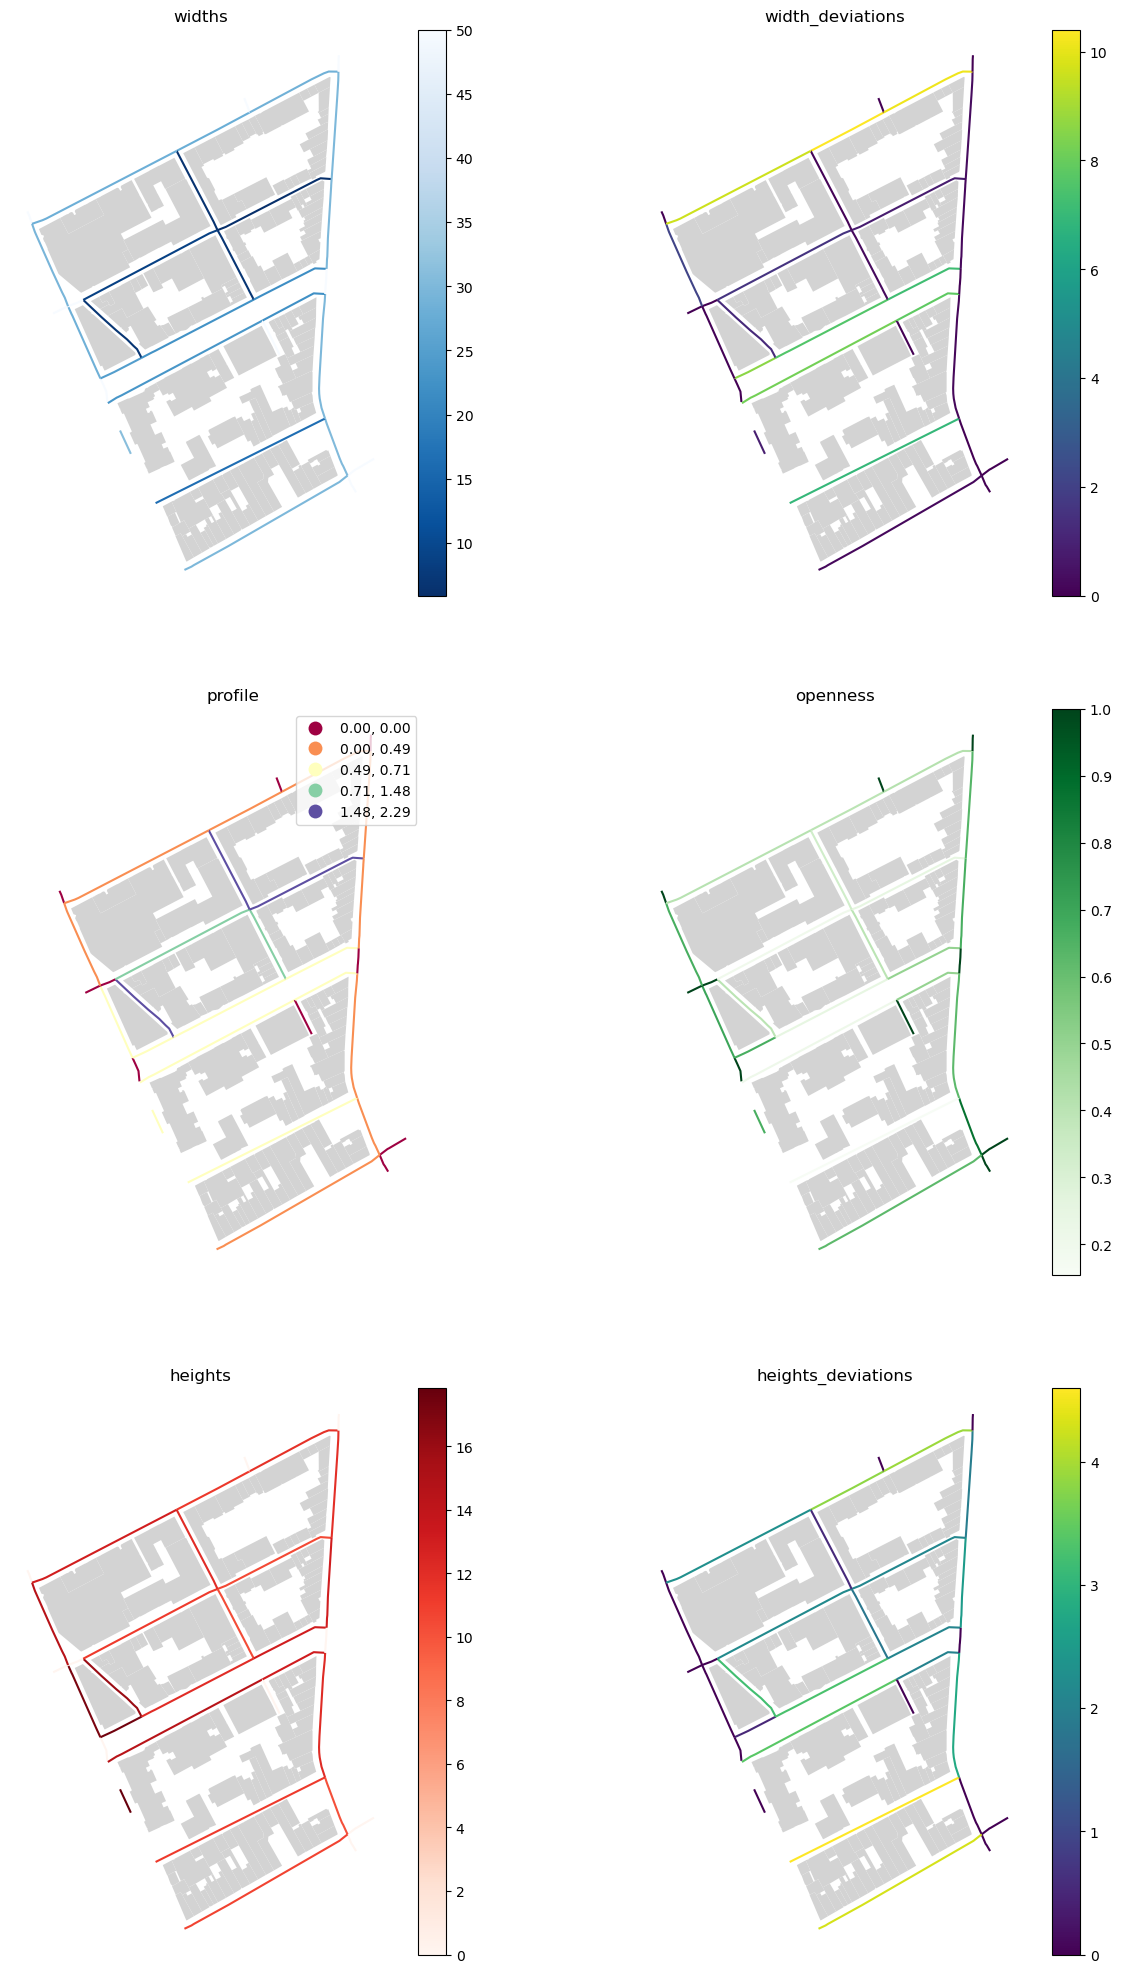

In [ ]:


ams_neighbourhoods = gpd.read_file('../data/raw_data/AMS/Admin_bounds/AMS_Neighbourhoods_excl_water_lnglat.json').to_crs(28992)
ams_neighbourhoods_sample = ams_neighbourhoods.sample()

bm_ams_sample = bm_ams.clip(ams_neighbourhoods_sample)
edges_ams_sample = edges_ams.clip(ams_neighbourhoods_sample)

f, axes = plt.subplots(figsize=(15, 25), ncols=2, nrows=3)
edges_ams_sample.plot(ax=axes[0][0], column='widths', legend=True, cmap='Blues_r')
bm_ams_sample.plot(ax=axes[0][0], color='lightgrey')
edges_ams_sample.plot(ax=axes[0][1], column='width_deviations', legend=True)
bm_ams_sample.plot(ax=axes[0][1], color='lightgrey')
axes[0][0].set_axis_off()
axes[0][0].set_title('widths')
axes[0][1].set_axis_off()
axes[0][1].set_title('width_deviations')
edges_ams_sample.plot(ax=axes[1][0], column='profile', legend=True, cmap='Spectral', scheme='natural_breaks')
bm_ams_sample.plot(ax=axes[1][0], color='lightgrey')
edges_ams_sample.plot(ax=axes[1][1], column='openness', legend=True, cmap='Greens')
bm_ams_sample.plot(ax=axes[1][1], color='lightgrey')
axes[1][0].set_axis_off()
axes[1][0].set_title('profile')
axes[1][1].set_axis_off()
axes[1][1].set_title('openness')
edges_ams_sample.plot(ax=axes[2][0], column='heights', legend=True, cmap='Reds')
bm_ams_sample.plot(ax=axes[2][0], color='lightgrey')
edges_ams_sample.plot(ax=axes[2][1], column='heights_deviations', legend=True)
bm_ams_sample.plot(ax=axes[2][1], color='lightgrey')
axes[2][0].set_axis_off()
axes[2][0].set_title('heights')
axes[2][1].set_axis_off()
axes[2][1].set_title('heights_deviations')
plt.savefig('../results/figures/ams_street_profile_sample.png', dpi=300)
plt.show()

##### To-do: Clean up the street profile

<AxesSubplot: >

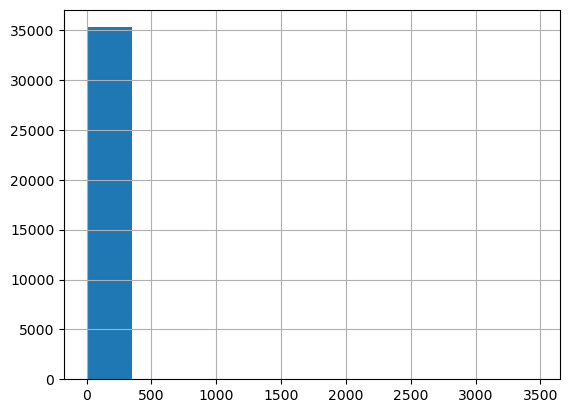

In [92]:
edges_ams.profile.hist()

In [56]:
edges_ams.profile.std()

31.48361085705929

DECIDED TO GO WITH NATIONAL DATA INSTEAD: https://nationaalgeoregister.nl/geonetwork/srv/dut/catalog.search#/metadata/60caa9e5-60c5-4072-a575-e11ef5a07mgl


Would have to simplify the network though. Might have to reach out to Martin for this? https://github.com/martinfleis/numerical-taxonomy-paper/blob/main/code_production/Amsterdam/200224_simplify_network.ipynb

In [60]:
#Calculate the mean and std of the profile column
data_mean, data_std = np.mean(edges_ams['profile']), np.std(edges_ams['profile'])

# Identify the outlier cutoff values
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off


# Cut outliers

edges_ams_clean = edges_ams.loc[edges_ams['profile'].gt(lower) & edges_ams['profile'].lt(upper)]
                              
edges_ams_clean

access  area bicycle bridge busway cycleway est_width  foot footway  \
251432   None  None    None   None   None     None      None  None    None   
251926   None  None    None   None   None     None      None  None    None   
741822   None  None    None   None   None     None      None  None    None   
251431   None  None    None   None   None     None      None  None    None   
251430   None  None    None   None   None     None      None  None    None   
...       ...   ...     ...    ...    ...      ...       ...   ...     ...   
376989   None  None    None   None   None     None      None  None    None   
376990   None  None    None   None   None     None      None  None    None   
376993   None  None    None   None   None     None      None  None    None   
376991   None  None    None   None   None     None      None  None    None   
376992   None  None    None   None   None     None      None  None    None   

             highway int_ref junction lanes   lit maxspeed motorcar motorroad  \
251432      cycleway    None     None  None  None     None     None      None   
251926  unclassified    None     None  None  None       80     None      None   
741822         track    None     None  None  None     None     None      None   
251431      cycleway    None     None  None  None     None     None      None   
251430      cycleway    None     None  None  None     None     None      None   
...              ...     ...      ...   ...   ...      ...      ...       ...   
376989       service    None     None  None  None     None     None      None   
376990       service    None     None  None  None     None     None      None   
376993       service    None     None  None  None     None     None      None   
376991       service    None     None  None  None     None     None      None   
376992       service    None     None  None  None     None     None      None   

       motor_vehicle     name oneway overtaking  path passing_places   psv  \
251432          None     None   None       None  None           None  None   
251926          None  Googpad   None       None  None           None  None   
741822          None     None   None       None  None           None  None   
251431          None     None   None       None  None           None  None   
251430          None     None   None       None  None           None  None   
...              ...      ...    ...        ...   ...            ...   ...   
376989          None     None   None       None  None           None  None   
376990          None     None   None       None  None           None  None   
376993          None     None   None       None  None           None  None   
376991          None     None   None       None  None           None  None   
376992          None     None   None       None  None           None  None   

         ref   service segregated sidewalk smoothness surface tracktype  \
251432  None      None       None     None       None    None      None   
251926  None      None       None     None       None    None      None   
741822  None      None       None     None       None    None    grade4   
251431  None      None       None     None       None    None      None   
251430  None      None       None     None       None    None      None   
...      ...       ...        ...      ...        ...     ...       ...   
376989  None  driveway       None     None       None    None      None   
376990  None  driveway       None     None       None    None      None   
376993  None  driveway       None     None       None    None      None   
376991  None  driveway       None     None       None    None      None   
376992  None  driveway       None     None       None    None      None   

       tunnel  turn width         id  timestamp  version  tags osm_type  \
251432   None  None  None   34948468          0       -1  None      way   
251926   None  None  None   35013060          0       -1  None      way   
741822   None  None  None  7474536

In [ ]:
f, axes = plt.subplots(figsize=(30, 50), ncols=2, nrows=3)
edges_ams_clean.plot(ax=axes[0][0], column='widths', legend=True, cmap='Blues_r')
bm_ams.plot(ax=axes[0][0], color='lightgrey')
edges_ams_clean.plot(ax=axes[0][1], column='width_deviations', legend=True)
bm_ams.plot(ax=axes[0][1], color='lightgrey')
axes[0][0].set_axis_off()
axes[0][0].set_title('widths')
axes[0][1].set_axis_off()
axes[0][1].set_title('width_deviations')
edges_ams_clean.plot(ax=axes[1][0], column='profile', legend=True, cmap='Spectral')
bm_ams.plot(ax=axes[1][0], color='lightgrey')
edges_ams_clean.plot(ax=axes[1][1], column='openness', legend=True, cmap='Greens')
bm_ams.plot(ax=axes[1][1], color='lightgrey')
axes[1][0].set_axis_off()
axes[1][0].set_title('profile')
axes[1][1].set_axis_off()
axes[1][1].set_title('openness')
edges_ams_clean.plot(ax=axes[2][0], column='heights', legend=True, cmap='Reds')
bm_ams.plot(ax=axes[2][0], color='lightgrey')
edges_ams_clean.plot(ax=axes[2][1], column='heights_deviations', legend=True)
bm_ams.plot(ax=axes[2][1], color='lightgrey')
axes[2][0].set_axis_off()
axes[2][0].set_title('heights')
axes[2][1].set_axis_off()
axes[2][1].set_title('heights_deviations')
plt.savefig('../results/figures/ams_street_profile_clean.png', dpi=300)
plt.show()

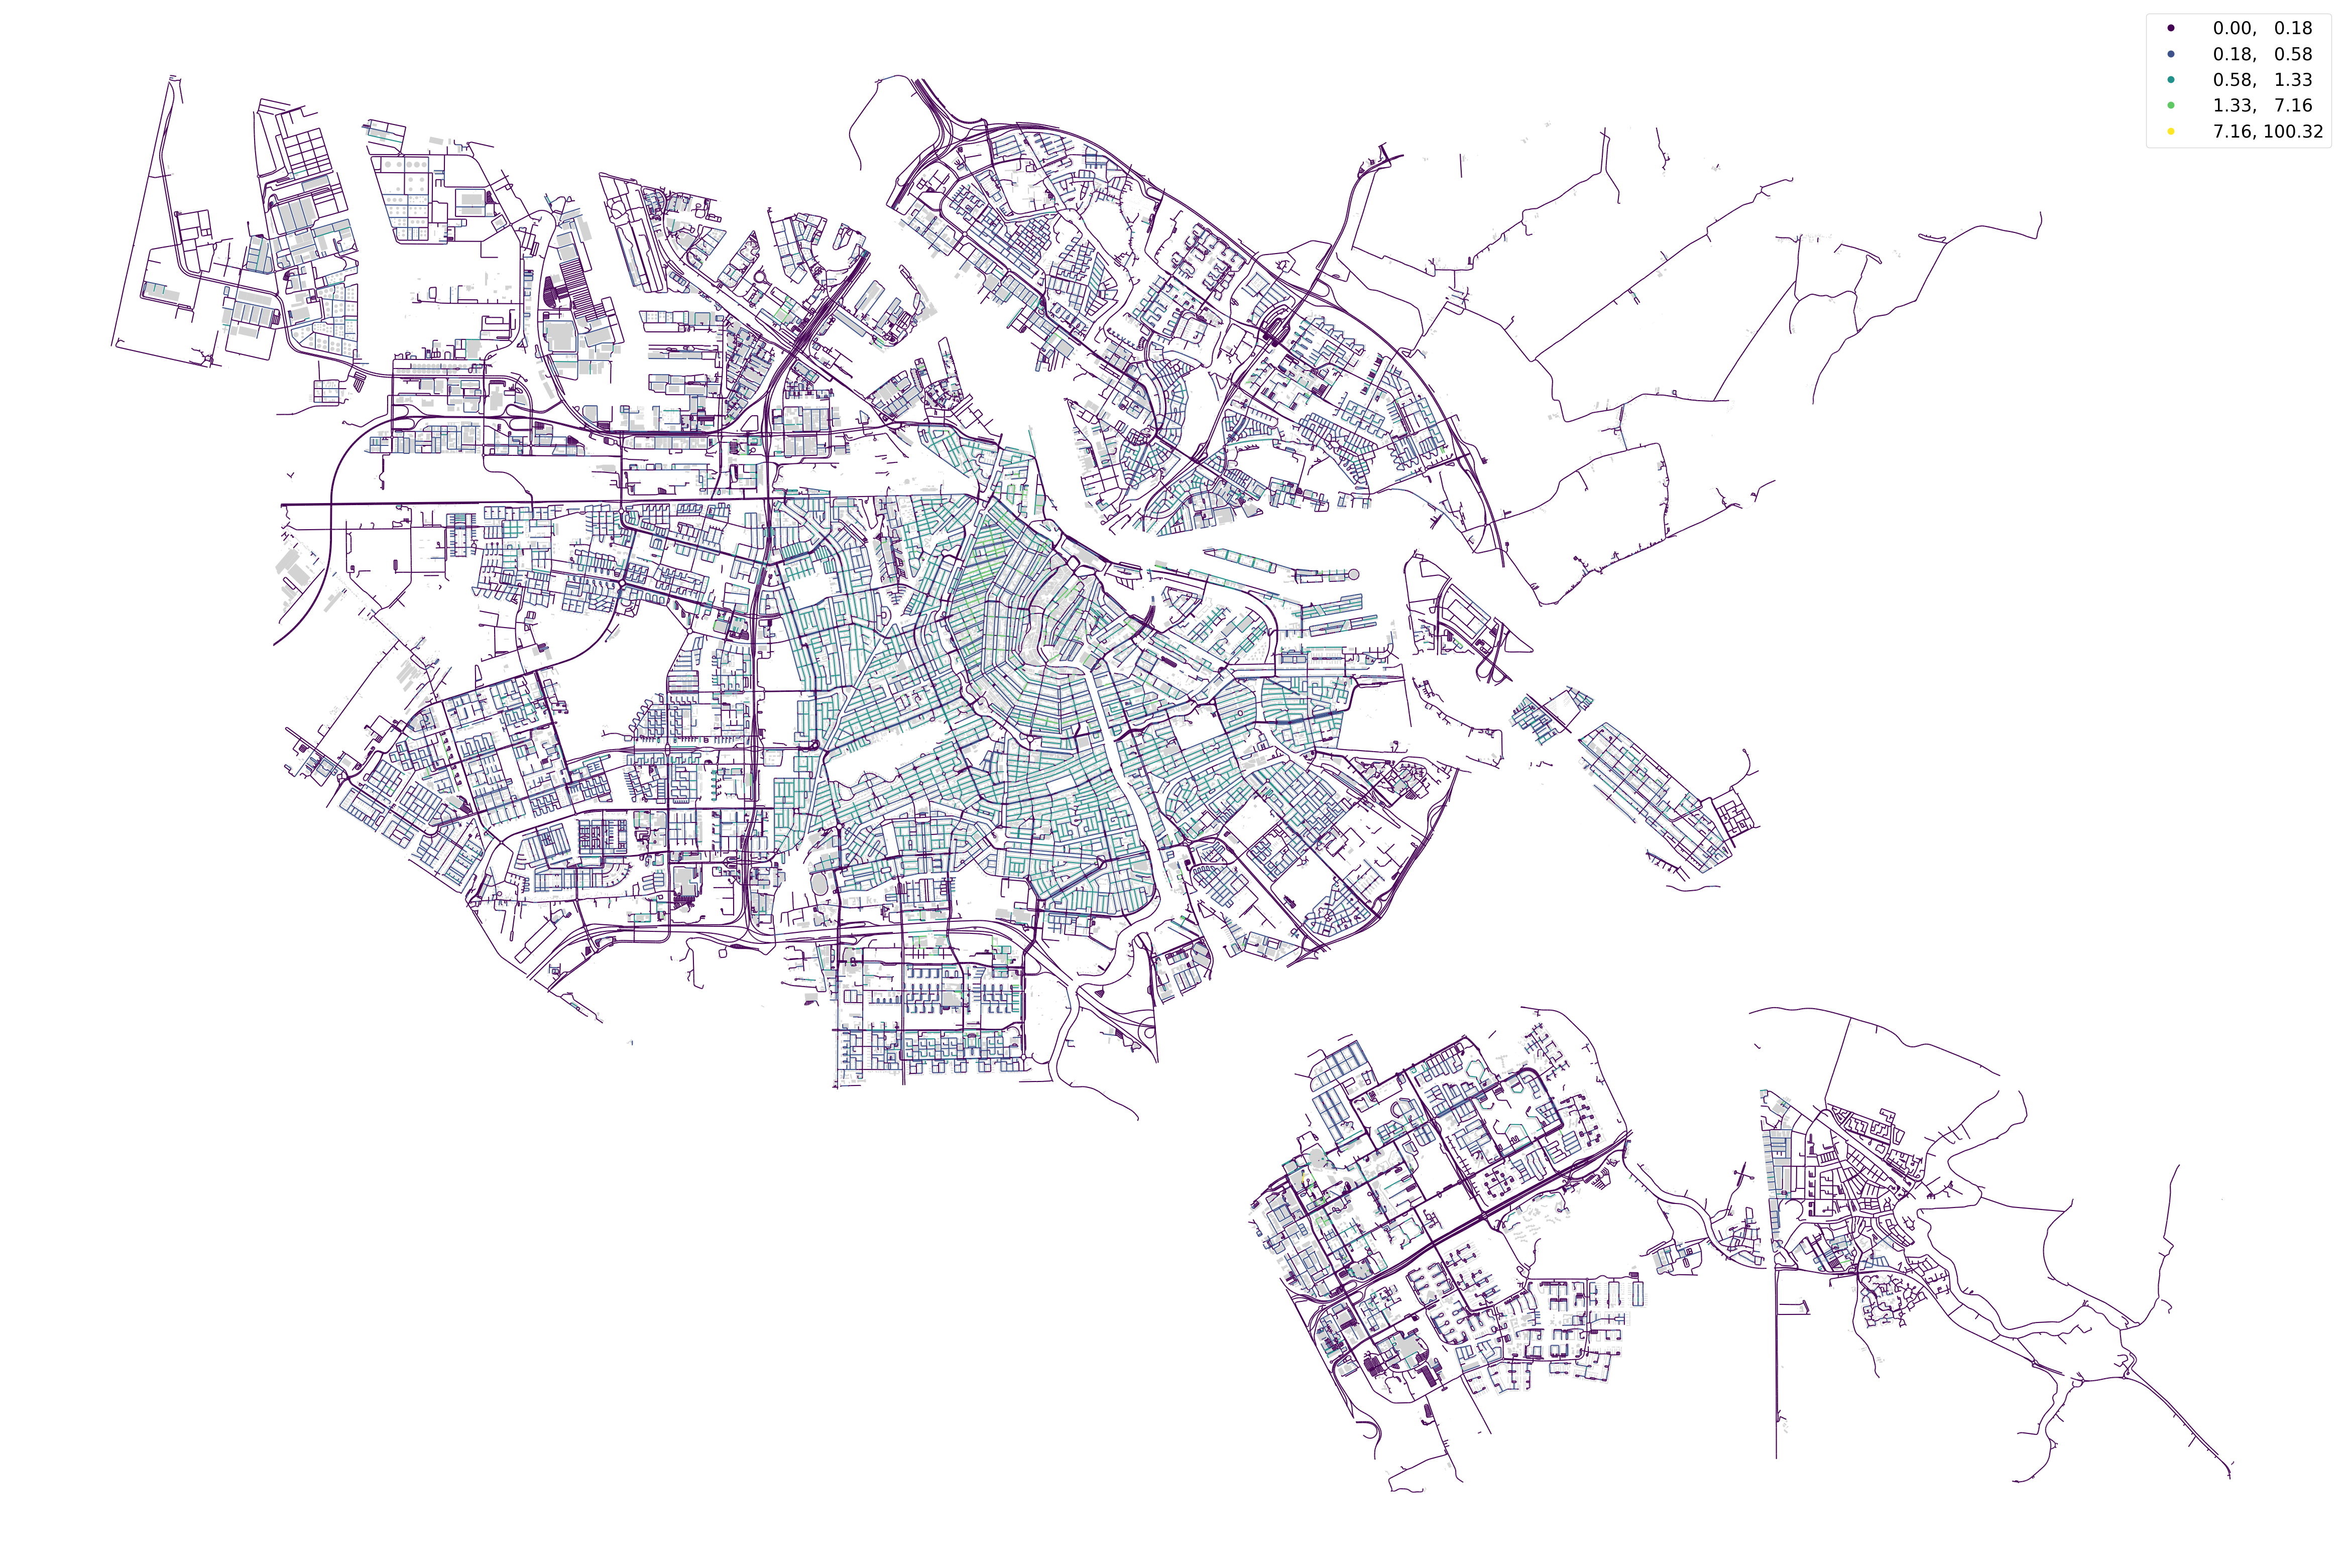

In [73]:
ax = edges_ams.plot(column='profile', figsize=(60,60), scheme='naturalbreaks', legend=True,  legend_kwds={'loc': 'best', 'fontsize': '25'})
bm_ams.plot(ax=ax, color='lightgrey')
ax.set_axis_off()
plt.savefig('../results/figures/ams_profile_just_driving.jpg', dpi=600)

In [74]:
edges_ams.to_file('../results/output/ams_street_profile.gpkg', driver='GPKG')

##### Visualisation: MarkerCluster

In [145]:
from folium.plugins import MarkerCluster

In [151]:
import pyproj

In [155]:
from pyproj import CRS

In [171]:
from functools import partial

In [ ]:
# Create a folium map object
m = folium.Map(location=[52.37, 4.90], zoom_start=12)

# Create a MarkerCluster object
marker_cluster = MarkerCluster(name="Tree locations", control=False, prefer_canvas=True, disableClusteringAtZoom=18).add_to(m)

# Set up the projections for the coordinate transformation
inProj = CRS.from_wkt('PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.15616055555555],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],AUTHORITY["EPSG","28992"]]')
outProj = pyproj.Proj(proj='longlat', datum='WGS84')

transformer = pyproj.Transformer.from_proj(inProj, outProj)

# Add markers to the MarkerCluster object
for idx, row in trees_ams.iterrows():
    x, y = row['geometry'].x, row['geometry'].y
    lon, lat = transformer.transform(x, y)
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(icon='leaf', icon_color='green'),
        popup=row['tree_name'] + " - " + "Height: " + str(row['bm_treeheight']) + " - " + "Diameter: " + str(row['bm_crown_diameter']),
    ).add_to(marker_cluster)
    
ams_parks.explore(m=m)
    
folium.TileLayer(tiles='CartoDB positron').add_to(m)
folium.LayerControl().add_to(m)
m.save("../results/output/trees_ams.html")
# Show the map
m